<a href="https://colab.research.google.com/github/PatriciaSojcakova/Zneus_Project2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from types import SimpleNamespace as Namespace
import pandas as pd

In [113]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_2/archive/sports.csv')

base_path = "/content/drive/MyDrive/Colab Notebooks/Project_2/archive/"
data['filepaths'] = base_path + data['filepaths']

#**1. Prieskumná analýza dát**

In [114]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


###**1.1 Deskriptívne štatistiky**

Počet obrázkov

In [115]:
print("Total images:", len(data))

Total images: 14493


Počet tried

In [116]:
print("Number of classes:", data['labels'].nunique())

Number of classes: 100


Distribúcia obrázkov v triedach

In [117]:
pd.set_option('display.max_rows', None)
display(data['labels'].value_counts())

,count
labels,
football,201
formula 1 racing,200
nascar racing,199
baseball,184
hockey,182
basketball,179
olympic wrestling,177
rugby,176
canoe slamon,174


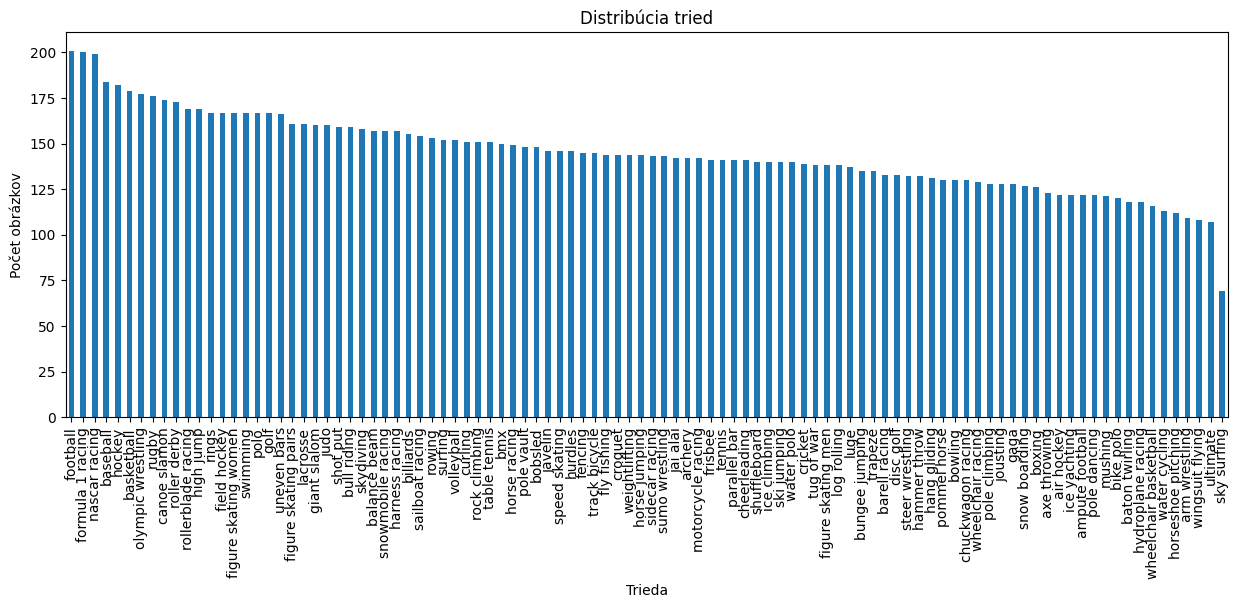

In [118]:
plt.figure(figsize=(15,5))
data['labels'].value_counts().plot(kind='bar')
plt.title("Distribúcia tried")
plt.xlabel("Trieda")
plt.ylabel("Počet obrázkov")
plt.show()

###**1.2 Výber tried**

Vybrali sme 10 tried na klasifikáciu.

In [119]:
"""
selected_labels = [
    'archery',
    'axe throwing',
    'basketball',
    'billiards',
    'bowling',
    'football',
    'formula 1 racing',
    'hockey',
    'horse jumping',
    'judo',
    'mushing',
    'rock climbing',
    'rowing',
    'snow boarding',
    'surfing',
    'swimming',
    'table tennis',
    'tennis',
    'volleyball',
    'wingsuit flying'
]
"""
selected_labels = [
    'football',
    'formula 1 racing',
    'basketball',
    'olympic wrestling',
    'hockey',
    'rugby',
    'canoe slamon',
    'rollerblade racing',
    'swimming',
    'rings',
]

data_filtered = data[data['labels'].isin(selected_labels)]

print(f"Original dataset shape: {data.shape}")
print(f"Filtered dataset shape: {data_filtered.shape}")

data = data_filtered.copy()


Original dataset shape: (14493, 4)
Filtered dataset shape: (1792, 4)


Nová distribúcia tried po filtrácii

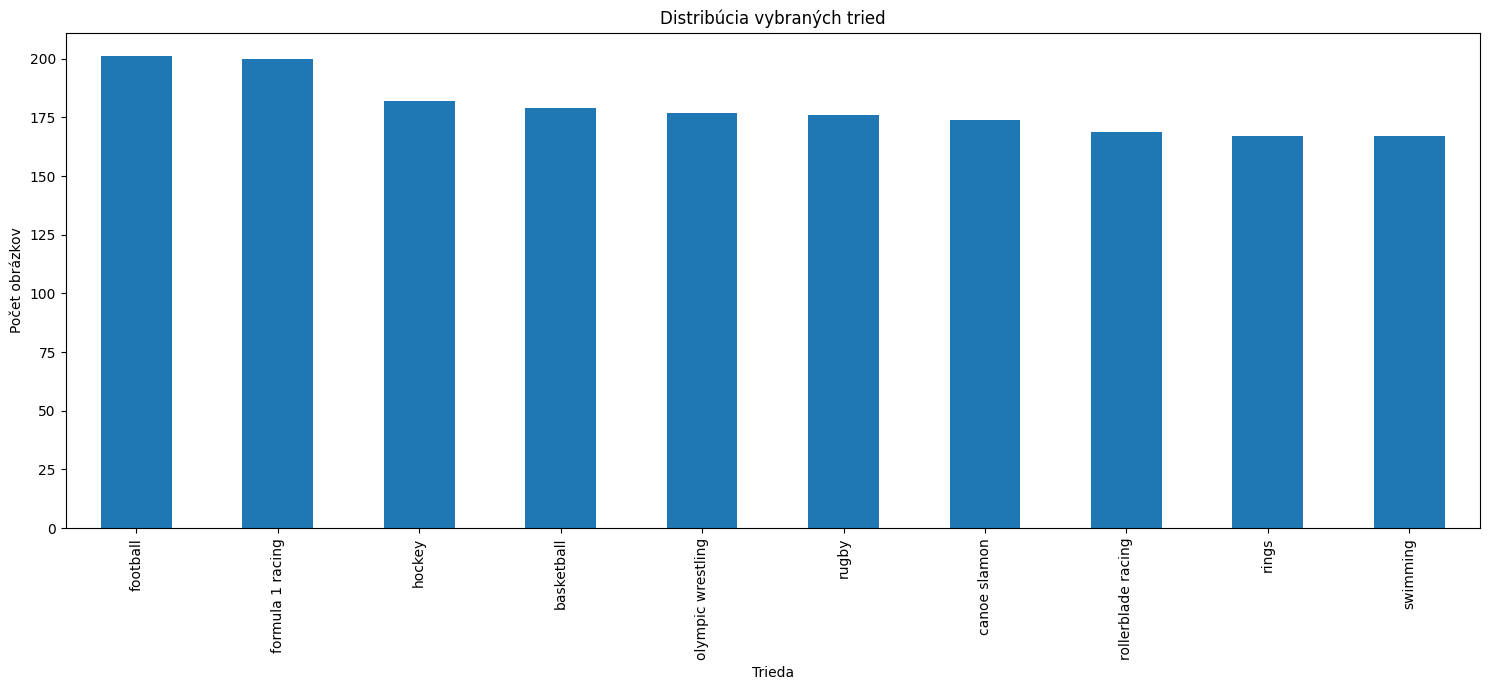

In [120]:
plt.figure(figsize=(15, 7))
data['labels'].value_counts().plot(kind='bar')
plt.title("Distribúcia vybraných tried")
plt.xlabel("Trieda")
plt.ylabel("Počet obrázkov")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

###**1.3 Vizualizácia náhodných obrázkov**

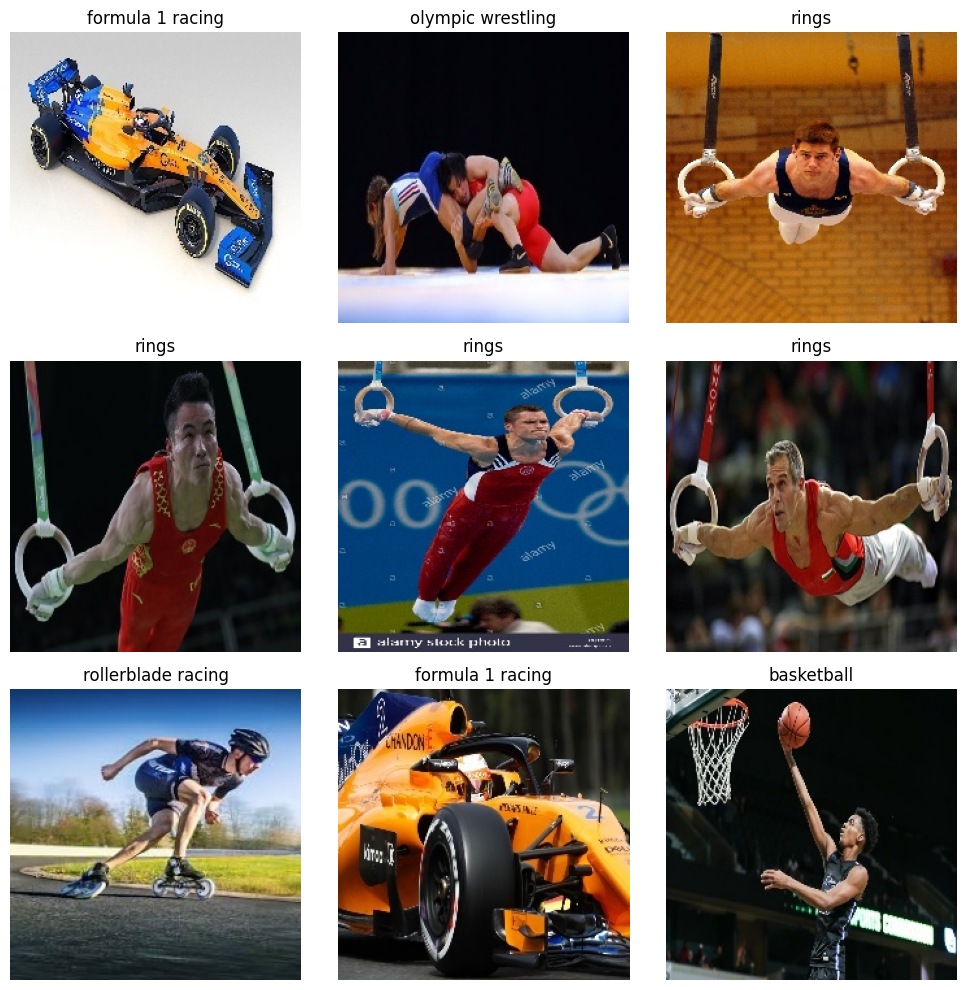

In [121]:
import random

sample = data.sample(9)

plt.figure(figsize=(10,10))
for i, row in enumerate(sample.itertuples(), 1):
    img = Image.open(row.filepaths)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(row.labels)
    plt.axis('off')
plt.tight_layout()
plt.show()

###**1.4 Kontrola duplikátov**

Skontrolovali sme duplikáty z hľadiska riadkov a ciest ku konkrétnym obrázkom. Dataset neobsahuje duplikáty.

In [122]:
print("Duplicated rows:", data.duplicated().sum())

Duplicated rows: 0


In [123]:
print("Duplicated filepaths:", data['filepaths'].duplicated().sum())

Duplicated filepaths: 0


In [124]:
'''import hashlib
from PIL import Image

def hash_image(path):
    with Image.open(path) as img:
        return hashlib.md5(img.tobytes()).hexdigest()

data['img_hash'] = data['filepaths'].apply(hash_image)

# počet duplikátov pixelovo
data['img_hash'].duplicated().sum()'''

"import hashlib\nfrom PIL import Image\n\ndef hash_image(path):\n    with Image.open(path) as img:\n        return hashlib.md5(img.tobytes()).hexdigest()\n\ndata['img_hash'] = data['filepaths'].apply(hash_image)\n\n# počet duplikátov pixelovo\ndata['img_hash'].duplicated().sum()"

###**1.5 Outliery**

Skontrolovali sme rozmery náhodnej vzorky obrázkov, pričom sme zistili, že rozmery obrázkov sú rovnaké, teda nemusíme riešiť outliery.

In [125]:
sample = data.sample(100, random_state=42)

widths = []
heights = []

for path in tqdm(sample['filepaths'], desc="Analyzing sample image sizes"):
    try:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        widths.append(np.nan)
        heights.append(np.nan)

sample['width'] = widths
sample['height'] = heights

Analyzing sample image sizes: 100%|██████████| 100/100 [00:00<00:00, 225.72it/s]


In [126]:
sample[['width', 'height']].describe()

,width,height
count,100.0,100.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


###**1.6 Kontrola poškodených obrázkov**

V náhodnej vzorke sme skontrolovali či sa v datasete môžu nachádzať poškodené obrázky. Výstupom je 0 chybných obrázkov.

In [127]:
sample = data.sample(400, random_state=42)

corrupted = []

for path in tqdm(sample['filepaths'], desc="Checking corrupted images (sample)"):
    try:
        Image.open(path).verify()
    except:
        corrupted.append(path)

print("\nPoškodené obrázky vo vzorke:", len(corrupted))

Checking corrupted images (sample): 100%|██████████| 400/400 [00:01<00:00, 385.02it/s]


Poškodené obrázky vo vzorke: 0


In [137]:
print("Počet vybraných obrázkov je", len(data))

Počet vybraných obrázkov je 1792


#**2. Preprocessing a základné augmentácie**

Všetky obrázky sme preškálovali na jednotnú veľkosť 224×224 pixelov a normalizovali pomocou ImageNet mean a std.
Tieto kroky zabezpečujú konzistentný vstup pre neurónovú sieť a stabilnejší tréning.

Na trénovacej množine sme použili tieto transformácie:

- náhodné horizontálne otočenie
- náhodná rotácia do ±10°
- jemná zmena jasu a kontrastu
- resize

Cieľom augmentácií je zvýšiť variabilitu datasetu a znížiť overfitting.

In [128]:
'''train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              # Preprocessing
    transforms.RandomHorizontalFlip(p=0.5),     # Augmentácie
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])'''

'train_transforms = transforms.Compose([\n    transforms.Resize((224, 224)),              # Preprocessing\n    transforms.RandomHorizontalFlip(p=0.5),     # Augmentácie\n    transforms.RandomRotation(10),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2),\n    transforms.ToTensor(),\n    transforms.Normalize(\n        mean=[0.485, 0.456, 0.406],\n        std=[0.229, 0.224, 0.225]\n    )\n])\n\nvalid_transforms = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize(\n        mean=[0.485, 0.456, 0.406],\n        std=[0.229, 0.224, 0.225]\n    )\n])'

In [129]:
'''
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
'''

'\ntrain_transforms = transforms.Compose([\n    transforms.Resize((128, 128)),\n    transforms.RandomHorizontalFlip(),\n    transforms.RandomRotation(10),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                         std=[0.229, 0.224, 0.225])\n])\n\nvalid_transforms = transforms.Compose([\n    transforms.Resize((128, 128)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                         std=[0.229, 0.224, 0.225])\n])\n'

In [173]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, 128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

TypeError: Scale should be a sequence

In [131]:
# Dataset
class SportsDataset(Dataset):
    def __init__(self, df, transform=None, class_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepaths']
        label_name = row['labels']
        label = self.class_to_idx[label_name]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [153]:
# DataModule pre obrázky
class ImageDataModule:
    def __init__(self, data, batch_size, num_workers, train_transforms, valid_transforms):
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    def setup(self):
        # split podľa stĺpca "data set"
        train_df = self.data[self.data['data set'] == 'train']
        valid_df = self.data[self.data['data set'] == 'valid']
        test_df  = self.data[self.data['data set'] == 'test']

        print("Train rows:", len(train_df))
        print("Valid rows:", len(valid_df))
        print("Test rows:", len(test_df))

        # mapovanie label -> index
        class_names = sorted(self.data['labels'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        self.num_classes = len(class_names)
        print("Classes:", class_names)
        print("num_classes:", self.num_classes)

        # datasety
        self.train_dataset = SportsDataset(train_df, transform=self.train_transforms,
                                           class_to_idx=self.class_to_idx,)
        self.val_dataset   = SportsDataset(valid_df, transform=self.valid_transforms,
                                           class_to_idx=self.class_to_idx)
        self.test_dataset  = SportsDataset(test_df,  transform=self.valid_transforms,
                                           class_to_idx=self.class_to_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)

In [133]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [134]:
'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
'''

In [158]:
'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
'''

In [161]:
'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1),   # Dropout v conv časti
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
'''

In [168]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [135]:
import matplotlib.pyplot as plt

class ImageTrainer:
    def __init__(self, model, data_module, cfg, device=None):
        self.model = model
        self.data_module = data_module
        self.cfg = cfg

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.train_loader = data_module.train_dataloader()
        self.val_loader   = data_module.val_dataloader()
        self.test_loader  = data_module.test_dataloader()

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.learning_rate)

        # logy na grafy
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1": [],
        }

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss = running_loss / len(self.val_loader.dataset)
        val_acc = correct / total
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)

        return val_loss, val_acc, val_f1, cm

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        test_acc = correct / total
        test_f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1 (macro): {test_f1:.4f}")
        print(f"Test Confusion Matrix:\n{cm}")

    def fit(self):
        for epoch in range(self.cfg.max_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_f1, cm = self.validate()

            # uloženie do history
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_f1"].append(val_f1)

            print(
                f"Epoch {epoch+1}/{self.cfg.max_epochs} - "
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}"
            )
            # print(f"Confusion Matrix (val):\n{cm}\n")

        # po tréningu: grafy
        self.plot_history()

    def plot_history(self):
        epochs = range(1, len(self.history["train_loss"]) + 1)

        plt.figure(figsize=(12, 4))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history["train_loss"], label="Train Loss")
        plt.plot(epochs, self.history["val_loss"], label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()

        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history["train_acc"], label="Train Acc")
        plt.plot(epochs, self.history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
cfg = Namespace(
    batch_size = 128,
    num_workers = 2,
    max_epochs = 55,
    learning_rate = 0.001,
)


data_module = ImageDataModule(
    data=data,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
)
data_module.setup()

#model = SimpleCNN(num_classes=data_module.num_classes)
model = CNN(num_classes=data_module.num_classes)

trainer = ImageTrainer(model, data_module, cfg)

trainer.fit()
trainer.test()

Train rows: 1692
Valid rows: 50
Test rows: 50
Classes: ['basketball', 'canoe slamon', 'football', 'formula 1 racing', 'hockey', 'olympic wrestling', 'rings', 'rollerblade racing', 'rugby', 'swimming']
num_classes: 10
Epoch 1/55 - Train Loss: 2.4253, Acc: 0.1147 | Val Loss: 1.9705, Acc: 0.3600, F1: 0.2769
Epoch 2/55 - Train Loss: 2.1411, Acc: 0.1921 | Val Loss: 1.8634, Acc: 0.3400, F1: 0.2627
Epoch 3/55 - Train Loss: 2.0532, Acc: 0.2098 | Val Loss: 1.6641, Acc: 0.3600, F1: 0.2958
Epoch 4/55 - Train Loss: 1.9820, Acc: 0.2565 | Val Loss: 1.5842, Acc: 0.4000, F1: 0.3392
Epoch 5/55 - Train Loss: 1.9065, Acc: 0.2801 | Val Loss: 1.5176, Acc: 0.4200, F1: 0.3889
Epoch 6/55 - Train Loss: 1.8478, Acc: 0.3109 | Val Loss: 1.4867, Acc: 0.4600, F1: 0.3886
Epoch 7/55 - Train Loss: 1.7423, Acc: 0.3670 | Val Loss: 1.3387, Acc: 0.5200, F1: 0.4931
Epoch 8/55 - Train Loss: 1.6924, Acc: 0.3877 | Val Loss: 1.2776, Acc: 0.5200, F1: 0.4786
Epoch 9/55 - Train Loss: 1.6798, Acc: 0.4161 | Val Loss: 1.2289, Acc: 0

In [ ]:
'''train_dir = "/content/drive/MyDrive/Colab Notebooks/Project_2/archive/train"
valid_dir = "/content/drive/MyDrive/Colab Notebooks/Project_2/archive/valid"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/Project_2/archive/test"

train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = ImageFolder(root=valid_dir, transform=valid_transforms)
test_dataset  = ImageFolder(root=test_dir, transform=valid_transforms)'''

In [ ]:
'''train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)'''

In [ ]:
#odtialto to funguje

'''train_df = data[data['data set'] == 'train']
valid_df = data[data['data set'] == 'valid']
test_df  = data[data['data set'] == 'test']

print("Train rows:", len(train_df))
print("Valid rows:", len(valid_df))
print("Test rows:", len(test_df))'''

In [ ]:
'''class_names = sorted(data['labels'].unique())
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
num_classes = len(class_names)
print("Classes:", class_names)
print("num_classes:", num_classes)'''

In [ ]:
'''class SportsDataset(Dataset):
    def __init__(self, df, transform=None, class_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepaths']
        label_name = row['labels']
        label = self.class_to_idx[label_name]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label'''


In [ ]:
'''train_dataset = SportsDataset(train_df, transform=train_transforms, class_to_idx=class_to_idx)
valid_dataset = SportsDataset(valid_df, transform=valid_transforms, class_to_idx=class_to_idx)
test_dataset  = SportsDataset(test_df,  transform=valid_transforms, class_to_idx=class_to_idx)

print("Train dataset size:", len(train_dataset))
print("Valid dataset size:", len(valid_dataset))
print("Test dataset size:", len(test_dataset))

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)'''

In [ ]:
'''import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)'''


In [ ]:
'''num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_idx = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_acc = batch_correct / inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validácia
    model.eval()
    valid_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_acc = correct / len(valid_loader.dataset)

    print(f"Epoch {epoch+1} | train loss: {epoch_loss:.3f} | "
          f"valid loss: {valid_loss:.3f} | valid acc: {valid_acc:.3f}")'''


In [ ]:
'''model.eval()
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.3f}")'''
